# Thesis data generation and analysis
---

## Setup

### Imports, variables and plotting setup

In [71]:
import os
import numpy as np
import string
import random

import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


# import configuration variable with path
# to the Golang code of the experiment
from config import EXPERIMENT_PATH

# build Golang program
os.system("go build -o " + EXPERIMENT_PATH + "/thesis " + EXPERIMENT_PATH + "/*.go")


# plotting config
plt.style.use('seaborn-talk')
sns.set_style("white")
sns.set_context("paper", font_scale=1.5)

np.random.seed(2424)

### Utility functions

In [72]:
# run experiment with given params
def runExperiment(name, algo="mt", i=10, op="build"):
    os.system(EXPERIMENT_PATH + "/thesis " + "-algo=" + algo +  " -op=" + op + " -name=" + name + " -iter=" + str(i))
    
# clean source and results folders
def cleanup():
    os.system("rm " + EXPERIMENT_PATH + "/source/*.txt")
    os.system("rm " + EXPERIMENT_PATH + "/results/*.txt")

In [75]:
# generate n transactions of uniformly distributed length
def genUniTransactions(n, name):
    # generate i uniformly randomly distributed integers n
    # between 900 and 1100. the block length is n*8 bytes
    lengths = np.rint(np.random.uniform(900, 1100, n))
    
    # the function gen_string is vectorized, ready to 
    # process arrays 
    vfunc = np.vectorize(random_string)
    
    # generates strings of given lengths
    samples = vfunc(lengths.astype(int))
    
    with open(EXPERIMENT_PATH + '/source/' + name, 'w') as output:
        for sample in samples:
            output.write(sample + '\n')

# generate random string of specified length
def random_string(length):
    return ''.join(random.choice(string.ascii_letters) for m in range(length))

---

## Experiment

### Uniformly random distributed transactions

Text(0,0.5,'Execution Time (µs)')

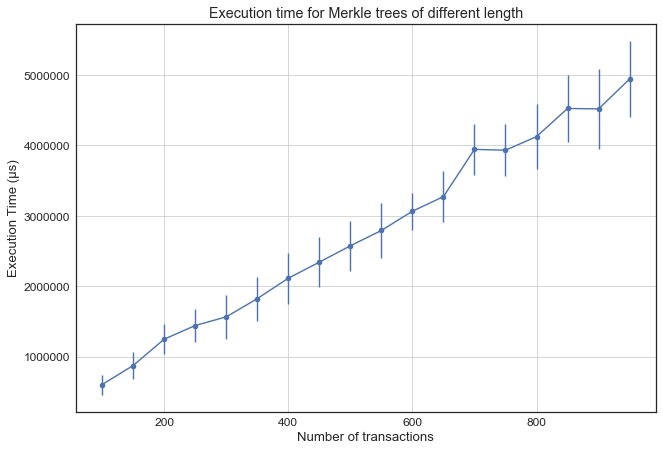

In [132]:
ALGO = 'mt'
RES_PATH = '/results/result_' + ALGO + '_'
NUM_TRIALS = 20

trials = np.arange(NUM_TRIALS)

for i in range(100, 1000, 50):
    SAMPLE = str(i) + '_uniform_samples.txt'

    # generate data
    genUniTransactions(i, SAMPLE)
    
    # run exeperiment
    runExperiment(SAMPLE, i=NUM_TRIALS)
    
    # load daya in-memory for analysis
    result = np.loadtxt(EXPERIMENT_PATH + RES_PATH + SAMPLE, dtype='int')
    trials = np.vstack([trials, result])

# clean folders, we have data in-memory
cleanup()

# compute means and standard deviations
means = np.mean(trials[1:,:], axis=1)
stds = np.std(trials[1:,:], axis=1)

lenghts = np.arange(100, 1000, 50)

# build plot
plt.errorbar(lenghts, means, yerr=stds, marker='o')
plt.title('Execution time for Merkle trees of different length')
plt.grid(True)
plt.xlabel('Number of transactions')
plt.ylabel('Execution Time (µs)')
print()